#### Lab 8
#### На основе ШАД Яндекс


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch

### 1. Нахождение сложной производной

Найдите производную по x от функции 
$$\sin\left(\tan(x)\frac{x^2}{y} + \ln(e^{-x^2 + 3}+x^3y)\right)\tan(x^2e^{x^9})$$

При этом надо пользоваться встроенным в PyTorch autograd. Численное вычисление производной может не дать нужный результат.

In [3]:
def find_x_derivative(x, y):
    # YOUR CODE HERE
    x = torch.tensor(data=x, dtype=torch.float, requires_grad=True)
    y = torch.tensor(data=y, dtype=torch.float, requires_grad=True)
    result = torch.sin(torch.tan(x)*torch.pow(x,2)/y + torch.log(torch.exp(torch.pow(-x,2) + 3) + torch.pow(x,3)*y)) * torch.tan(torch.pow(x,2)*torch.exp(torch.pow(x,9)))
    return result.item()
    # YOUR CODE HERE
find_x_derivative(1.5, 2)

0.3392165005207062

# 2. Нахождение косинусной близости

Вам даны две матрицы A и B. Необходимо посчитать косинусную близость между строчками матрицы A и столбцами матрицы B. Ответ - матрица чисел, где номер строки - номер строки из матрицы А, а номер столбца - номер столбца из В, от которых бралась косинусная близость.

Напомним, что косинусная близость двух векторов - косинус угла между ними. В n-мерном пространстве косинус угла между веткорами удобнее всего через скалярное произведение:
$$\cos(angle(x, y)) = \frac{x \cdot y}{\left\|x\right\| \left\|y\right\|}$$

(Наша операция очень похожа на умножение матриц)

In [4]:
def get_cos_sim(A, B):
    """
        A, B - torch float tensors
    """
    # YOUR CODE HERE
    cos = torch.mm(A, B)/(torch.sqrt(torch.mm(A,A))*torch.sqrt(torch.mm(B,B)))
    return cos
    # YOUR CODE HERE
    
a = torch.tensor([[1, 2], [4, 6]], dtype=torch.float)
b = torch.tensor([[0, 2], [8, 10]], dtype=torch.float)
get_cos_sim(a, b)

tensor([[1.3333, 1.3148],
        [1.0142, 0.9518]])

# 3. Линейная регрессия

Раньше мы самостоятельно считали производные, чтобы находить веса линейной регрессии с помощью градиентного спуска. Теперь нам нужно использовать для этого PyTorch и его autograd. 

**Важно**: на самом деле .backward не обновляет содержимое матриц с производными (some_tensor.grad), а прибавляет к ним только что посчитаные значения проивзодных. Это значит, что вызвав .backward дважды, вы получите удвоенную производную. Так как мы обновляем веса в цикле и много раз вызываем .backward, то очень быстро мы получим мусор в some_tensor.grad, если не будем его каждый раз обнулять. Таким образом, в конц итериации после использования производных обнулите значения в матрице производных для всех нужных Вам переменных. Делается это вот так 
> some\_tensor.grad.data.zero_()

In [5]:
class LinearRegression:
    def get_loss(self, preds, y):
        """
            @param preds: предсказания модели
            @param y: истиные значения
            @return mse: значение MSE на переданных данных
        """
        # возьмите средний квадрат ошибки по всем выходным переменным
        # то есть сумму квадратов ошибки надо поделить на количество_элементов * количество_таргетов
        mse = torch.mean((preds - y)**2)
        return mse
        #YOUR_CODE
    
    def init_weights(self, input_size, output_size):
        """
            Инициализирует параметры модели
            W - матрица размерности (input_size, output_size)
            инициализируется рандомными числами из
            uniform распределения (torch.rand())
            b - вектор размерности (1, output_size)
            инициализируется нулями
        """
        torch.manual_seed(0) #необходимо для воспроизводимости результатов
        self.W = torch.rand(input_size, output_size,  requires_grad=True)
        self.b = torch.zeros(1, output_size, requires_grad=True)

    def fit(self, X, y, num_epochs=1000, lr=0.001):
        """
            Обучение модели линейной регрессии методом градиентного спуска
            @param X: размерности (num_samples, input_shape)
            @param y: размерности (num_samples, output_shape)
            @param num_epochs: количество итераций градиентного спуска
            @param lr: шаг градиентного спуска
            @return metrics: вектор значений MSE на каждом шаге градиентного
            спуска.
        """
        self.init_weights(X.shape[1], y.shape[1])
        metrics = []
        for _ in range(num_epochs):
            preds = self.predict(X)
            # сделайте вычисления градиентов c помощью Pytorch и обновите веса
            # осторожнее, оберните вычитание градиента в 
#                 with torch.no_grad():
#                     #some code
            # иначе во время прибавления градиента к переменной создастся очень много нод в дереве операций
            # и ваши модели в будущем будут падать от нехватки памяти
            #YOUR_CODE
            mse = self.get_loss(preds, y)
            with torch.no_grad():
                mse.backward()
                self.W -= lr * self.W.grad
                self.b -= lr * self.b.grad
            self.W.grad.zero_()
            self.b.grad.zero_()
            metrics.append(self.get_loss(preds, y).data)
        return metrics

    def predict(self, X):
        """
            Думаю, тут все понятно. Сделайте свои предсказания :)
        """
        return torch.mm(X, self.W) + self.b
        #YOUR_CODE

1. Сгенерируйте данные с помощью make_regression с параметрами n_targets=3, n_features=2, noise=10, random_state=42. 
2. Обучите модель линейной регрессии, оставив в fit параметры num_epochs и lr по умолчанию (обратите внимание, что перед обучением нужно привести данные к типу, использующимся в torch) 
2. Посчитайте среднее значение метрики MSE по всем итерациям цикла в fit (массив из значений MSE на каждой итерации возвращается из метода fit). Ответом, который необходимо сдать в систему, будет число, округленное до 3х знаков после запятой.

In [6]:
X, Y = datasets.make_regression(n_targets=3, n_features=2, noise=10, random_state=42)
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)
model = LinearRegression()
mse = model.fit(X, Y)

In [7]:
print(np.mean(mse))

4256.561


Здесь предлагаем протестировать метод predict удобным вам образом.

In [8]:
#YOUR CODE

In [24]:
res_predict=model.predict(X)
res_predict

tensor([[  6.8541,   0.5543,  -1.5183],
        [-56.6351, -42.0323, -39.0554],
        [-62.4823, -31.9040, -25.9731],
        [-42.1749, -32.7359, -30.9805],
        [  8.4156,  15.5514,  15.8258],
        [-53.5753, -26.0870, -20.8924],
        [ 45.9922,  33.3924,  29.3737],
        [ 31.4741,  14.5750,  10.1026],
        [ 66.9552,  45.2404,  39.1624],
        [-16.9052, -11.5615, -11.0675],
        [-11.2921,  -0.6256,   0.6923],
        [ 43.6821,  15.3659,   8.6121],
        [ 36.0577,  18.8220,  14.1928],
        [  3.1521,  -2.0366,  -3.8338],
        [-83.2639, -57.4035, -51.8676],
        [ 18.9995,  11.4185,   8.8614],
        [-39.4610, -19.9890, -16.5138],
        [-21.7515, -24.2949, -25.0953],
        [ 44.3900,  25.7567,  20.7032],
        [ -3.4867, -10.4673, -12.4412],
        [ 30.3031,  30.5916,  29.1889],
        [-17.6429,  -7.5654,  -6.2171],
        [-12.7887,  -4.2539,  -3.2819],
        [ 29.5546,  22.2569,  19.5261],
        [ -7.4601,   3.1827,   4.4151],


In [25]:
y_test = X[:,0]
y_test

tensor([ 0.4041, -0.5663, -1.9133, -0.3092, -0.8207, -1.7630,  0.4128,  1.0035,
         0.9313, -0.3011, -0.8572,  1.8523,  0.9686,  0.3571, -1.1962,  0.3464,
        -1.2457,  0.4736,  0.9755,  0.6117, -0.5183, -0.7144, -0.6451,  0.1714,
        -0.9094, -1.2208, -0.5035,  0.2611, -0.2990,  0.1746, -1.4635, -0.8023,
         0.8272, -0.2917,  0.3015,  0.7519, -1.0577,  0.7140, -1.1687,  2.1905,
         0.2323,  0.1846,  2.7202, -0.0265,  1.5230,  1.3071,  0.7818, -0.7198,
        -1.2309, -1.4123, -0.2346,  0.7871,  1.3562,  0.4825, -0.5018,  0.1109,
         1.4535, -0.2258,  1.5646,  0.8219,  0.3757, -0.3221, -0.1383, -0.3277,
        -1.4247,  0.1969, -1.9597,  1.5499, -1.3205,  0.5426,  0.3288,  0.5133,
         0.6566, -0.3851, -0.5623, -0.7537, -0.8158,  2.4632,  0.3853, -0.4206,
         0.3412,  0.4738,  0.7674, -1.1430,  1.8968,  0.0686, -0.4657,  0.8564,
         1.5380, -1.9876, -0.1857, -0.2341,  0.3142, -0.0744,  1.0571, -1.5148,
        -0.0728,  0.1537, -1.4019,  0.29

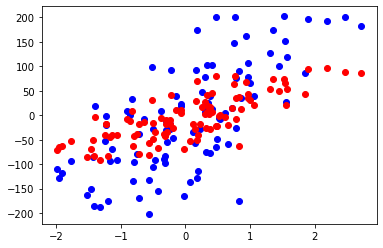

In [27]:
plt.scatter(X[:,0],Y[:,0], color='blue', marker='o')
plt.scatter(y_test,res_predict[:,0].detach(), color='red')